In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pathlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import pypower as pp
from pypower.api import runopf, ppoption
ppopt = ppoption(VERBOSE=0, OUT_ALL=0, OPT={'OPF_ALG': 560})
from pypower import case9, case14, case30, case57, case118, case300
cases = {
    "case9": case9,
    "case14": case14,
    "case30": case30,
    "case57": case57,
    "case118": case118,
    "case300": case300,
}

def run_opf(case, Pd, Qd):

    # Get load bus indices
    inds = np.arange(case["bus"].shape[0])
    load_buses_idx = list(inds[(case["bus"][:,2] != 0) | (case["bus"][:,3] != 0)].astype(object))
    
    # Update case load vector
    case["bus"][load_buses_idx, 2] = Pd
    case["bus"][load_buses_idx,3] = Qd
    
    # Solve case
    results = runopf(case, ppopt)
    if results["success"]:
        cost = results["f"]
    else:
        cost = np.nan

    return cost

# -----------------------------
# Standard Feedforward NN Model
# -----------------------------
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------
# Input Convex Neural Network
# -----------------------------
class ICNN(nn.Module):
    def __init__(self, input_dim):
        super(ICNN, self).__init__()
        self.flatten = nn.Flatten()

        # First hidden layer
        self.first_hidden_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU()
        )

        # ICNN hidden layers with non-negative W_z
        self.second_layer_linear_prim = nn.Linear(512, 512)
        self.second_layer_linear_skip = nn.Linear(input_dim, 512)
        self.second_layer_act = nn.ReLU()

        self.third_layer_linear_prim = nn.Linear(512, 256)
        self.third_layer_linear_skip = nn.Linear(input_dim, 256)
        self.third_layer_act = nn.ReLU()

        self.fourth_layer_linear_prim = nn.Linear(256, 64)
        self.fourth_layer_linear_skip = nn.Linear(input_dim, 64)
        self.fourth_layer_act = nn.ReLU()

        self.fifth_layer_linear_prim = nn.Linear(64, 16)
        self.fifth_layer_linear_skip = nn.Linear(input_dim, 16)
        self.fifth_layer_act = nn.ReLU()

        self.output_layer_linear_prim = nn.Linear(16, 1)
        self.output_layer_linear_skip = nn.Linear(input_dim, 1)

        # Non-negative weights
        self.nonneg_layers = [layer for name, layer in self.named_modules() if
                              isinstance(layer, nn.Linear) and "prim" in name]

        # Enforce non-negative weights at initialization
        self.clamp_nonneg_weights()

    def clamp_nonneg_weights(self):
        for name, layer in self.named_modules():
            if isinstance(layer, nn.Linear) and "prim" in name:
                layer.weight.data.clamp_(min=0)

    def forward(self, x):
        x = self.flatten(x)
        z1 = self.first_hidden_layer(x)
        z2 = self.second_layer_act(self.second_layer_linear_prim(z1) + self.second_layer_linear_skip(x))
        z3 = self.third_layer_act(self.third_layer_linear_prim(z2) + self.third_layer_linear_skip(x))
        z4 = self.fourth_layer_act(self.fourth_layer_linear_prim(z3) + self.fourth_layer_linear_skip(x))
        z5 = self.fifth_layer_act(self.fifth_layer_linear_prim(z4) + self.fifth_layer_linear_skip(x))
        out = self.output_layer_linear_prim(z5) + self.output_layer_linear_skip(x)
        return out

# -----------------------------
# Training Functions
# -----------------------------

def train(model, dataloader, optimizer, loss_fn, scheduler=None, max_norm=None):
    # Prepare model for training
    model.train()
    loss_arr = []
    for X, y in dataloader:
        # Get prediction / loss
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_arr.append(loss.item())
        # Do backpropagation
        optimizer.zero_grad()
        loss.backward()
        # Gradient clip (optional)
        if max_norm:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        # Update weights
        optimizer.step()
        # Optional clamping (for ICNN)
        if isinstance(model, ICNN):
            model.clamp_nonneg_weights()
    return np.mean(loss_arr)

def test(model, dataloader, loss_fn):
    model.eval()
    loss_arr = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            loss_arr.append(loss.item())
    return np.mean(loss_arr)

def pred(model, dataloader):
    model.eval()
    pred_arr = []
    with torch.no_grad():
        for X, _ in dataloader:
            pred = model(X)
            pred_arr.append(pred.item())
    return np.array(pred_arr)

def train_loop(model, train_loader, test_loader, loss_fn, optimizer, scheduler=None, epochs=1000, max_norm=None):
    # Loop through epochs of training / testing
    train_history, test_history = [], []
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        train_loss = train(model, train_loader, optimizer, loss_fn, scheduler=scheduler, max_norm=max_norm)
        train_history.append(train_loss)
        test_loss = test(model, test_loader, loss_fn)
        test_history.append(test_loss)
        # Scheduler step
        if scheduler:
            scheduler.step()
    print("Done!")
    return model, train_history, test_history

def create_train_test_datasets(X, y):

    # Create train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

    return X_train, y_train, X_test, y_test

def create_batches(X, y, batch_size, shuffle=True):
    
    # Convert to tensors
    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    # Get training / testing data loaders
    data = data_utils.TensorDataset(X, y)
    data_loader = data_utils.DataLoader(data, batch_size=batch_size, shuffle=shuffle)

    return data_loader

def train_model(model, train_loader, test_loader, optimizer="SGD", n_epochs=5000, learning_rate=0.1, weight_decay=0.0, scheduler_step_size=None, scheduler_gamma=None, max_norm=None):
    
    # # Select device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(f"Using {device} device")
    # model.to(device)
    
    # Loss function
    loss_fn = nn.MSELoss()  # Mean square error
    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Scheduler
    if (scheduler_step_size is not None) or (scheduler_gamma is not None):
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    else:
        scheduler = None
    
    # Train model
    print("Training...")
    model, train_history, test_history = train_loop(model, train_loader, test_loader, loss_fn, optimizer, epochs=n_epochs, scheduler=scheduler, max_norm=max_norm)
    
    return model, train_history, test_history

def save_model(model, save_path):
    # Save model weights
    torch.save(model.state_dict(), save_path)

def load_model(model, save_path):
    # Load saved model weights
    model.load_state_dict(torch.load(save_path, weights_only=True))

Using cpu device


In [ ]:
# -----------------------------
# Create Training Data
# -----------------------------

# Generate training data for f(x) = x^2 - alpha x^4 (non-convex)
np.random.seed(0)
torch.manual_seed(0)

def f(x, alpha=0.):
    return x ** 2 - alpha * x ** 4

n_samples = 5000
X = 4 * np.random.randn(n_samples).reshape(-1, 1)
y = f(X)
    
# -----------------------------
# Train Both Models
# -----------------------------

# Create training/testing data sets
X_train, y_train, X_test, y_test = create_train_test_datasets(X, y)
train_loader1 = create_batches(X_train, y_train, batch_size=200)
train_loader2 = create_batches(X_train, y_train, batch_size=50)
test_loader = create_batches(X_test, y_test, batch_size=50)

# Initialize models
nn_model = FCNN(input_dim=1)
icnn_model = ICNN(input_dim=1)

# Train models

# Phase 1: SGD
nn_model, nn_train_history_phase1, nn_test_history_phase1 = train_model(
    nn_model,
    train_loader1,
    test_loader,
    optimizer="SGD", 
    n_epochs=500,
    learning_rate=0.01,
    weight_decay=1e-9,
    scheduler_step_size=64,
    scheduler_gamma=0.8,
    max_norm=3.0
)

# Phase 2: Adam
nn_model, nn_train_history_phase2, nn_test_history_phase2 = train_model(
    nn_model,
    train_loader2,
    test_loader,
    optimizer="Adam", 
    n_epochs=500,
    learning_rate=0.0001,
    weight_decay=1e-9,
    scheduler_step_size=64,
    scheduler_gamma=0.8,
    max_norm=3.0
)
nn_train_history = nn_train_history_phase1 + nn_train_history_phase2
nn_test_history = nn_test_history_phase1 + nn_test_history_phase2

# Phase 1: SGD
icnn_model, icnn_train_history_phase1, icnn_test_history_phase1 = train_model(
    icnn_model,
    train_loader1,
    test_loader,
    optimizer="SGD",
    n_epochs=500,
    learning_rate=0.1,
    weight_decay=1e-9,
    scheduler_step_size=64,
    scheduler_gamma=0.8,
    max_norm=3.0
)

# Phase 2: Adam
icnn_model, icnn_train_history_phase2, icnn_test_history_phase2 = train_model(
    icnn_model,
    train_loader2,
    test_loader,
    optimizer="Adam",
    n_epochs=500,
    learning_rate=0.0001,
    weight_decay=1e-9,
    scheduler_step_size=64,
    scheduler_gamma=0.8,
    max_norm=3.0
)
icnn_train_history = icnn_train_history_phase1 + icnn_train_history_phase2
icnn_test_history = icnn_test_history_phase1 + icnn_test_history_phase2

# -----------------------------
# Plotting
# -----------------------------

x_test = torch.linspace(-15, 15, 200).reshape(-1, 1)
y_true = f(x_test)

with torch.no_grad():
    y_nn_pred = nn_model(x_test)
    y_icnn_pred = icnn_model(x_test)

plt.figure(figsize=(10, 5))
plt.plot(x_test, y_true, label='True $f(x) = x^2 - \\alpha x^4$', color='black')
plt.plot(x_test, y_nn_pred, label='Standard NN', linestyle='--')
plt.plot(x_test, y_icnn_pred, label='ICNN', linestyle='-.')
plt.legend()
plt.show()

# Test model
plt.title("ICNN Train / Test Error")
plt.plot(np.sqrt(np.array(icnn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(icnn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, None, 0, 10])
plt.show()

plt.title("NN Train / Test Error")
plt.plot(np.sqrt(np.array(nn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(nn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, None, 0, 10])
plt.show()

In [2]:
nn_training_parameters = {
    "case9": {
        1: dict(
            learning_rate=0.01,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=5.0
        ),
        2: dict(
            learning_rate=0.00001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=1.0
        )
    },
    "case14": {
        1: dict(
            learning_rate=0.01,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=3.0
        ),
        2: dict(
            learning_rate=0.000001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=1.0
        )
    },
    "case30": {
        1: dict(
            learning_rate=0.01,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=3.0
        ),
        2: dict(
            learning_rate=0.000001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=1.0
        )
    },
    "case118": {
        1: dict(
            learning_rate=0.001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=5.0
        ),
        2: dict(
            learning_rate=0.00001,
            scheduler_step_size=200,
            scheduler_gamma=0.7,
            max_norm=1.0
        )
    },
}


icnn_training_parameters = {
    "case9": {
        1: dict(
            learning_rate=0.001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=5.0,
        ),
        2: dict(
            learning_rate=0.0001,
            scheduler_step_size=200,
            scheduler_gamma=0.7,
            max_norm=1.0
        )
    },
    "case14": {
        1: dict(
            learning_rate=0.001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=5.0,
        ),
        2: dict(
            learning_rate=0.0001,
            scheduler_step_size=200,
            scheduler_gamma=0.7,
            max_norm=1.0
        )
    },
    "case30": {
        1: dict(
            learning_rate=0.001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=5.0,
        ),
        2: dict(
            learning_rate=0.0001,
            scheduler_step_size=200,
            scheduler_gamma=0.7,
            max_norm=1.0
        )
    },
    "case118": {
        1: dict(
            learning_rate=0.001,
            scheduler_step_size=500,
            scheduler_gamma=0.9,
            max_norm=5.0,
        ),
        2: dict(
            learning_rate=0.00001,
            scheduler_step_size=200,
            scheduler_gamma=0.7,
            max_norm=1.0
        )
    },
}

In [69]:
# -----------------------------
# Training / Testing for IEEE Case Data
# -----------------------------

# cases = ["case9", "case14", "case30", "case118", "case300"]

# Define case name, input dimension, number of samples
case_name = "case300"
input_dim = 60
num_samples = 100000
print(f"Case: {case_name} | Input Dimension: {input_dim} | Num. Samples: {num_samples}")

curr_dir = pathlib.Path(".")
data_dir = curr_dir / "training_data" / case_name
model_dir = curr_dir / "models" / case_name
model_dir.mkdir(exist_ok=True)
results_dir = curr_dir / "results" / case_name
results_dir.mkdir(exist_ok=True)

### Load IEEE case data

# Get case data
case = cases[case_name].__dict__[case_name]()
bus_data = case["bus"]

# Convert to dataframe
bus_columns = ["bus_ID", "bus_type", "Pd", "Qd", "Gs", "Bs", "area_number", "Vm", "Va", "basekV", "zone", "maxVm", "minVm"]
assert len(bus_columns) == bus_data.shape[1]

# Organize data
df_bus = pd.DataFrame(data=bus_data, columns=bus_columns)
df_bus[["bus_ID", "bus_type", "area_number", "zone"]] = df_bus[["bus_ID", "bus_type", "area_number", "zone"]].astype(np.int64)
df_bus = df_bus.set_index("bus_ID")

# Load buses
load_buses = list(df_bus.index[(df_bus[["Pd", "Qd"]] != 0.0).any(axis=1)])

### Load IEEE case SDP OPF cost training data for ICNN

# Load data
df_data = pd.read_csv(data_dir / f"training_{case_name}_{input_dim}d_{num_samples}samples.csv")

# Get feasible data points only
df_data = df_data.loc[(df_data["Feas_Flag"] == 1) & (df_data["Global_Opt"] == 1)]
print("Number of valid samples: ", len(df_data))

# Organize data
num_load_buses = int((len(df_data.columns) - 3) / 2)
print("Number of load buses: ", num_load_buses)
assert num_load_buses == len(load_buses)
X_columns = [f"Pd{i}" for i in load_buses] + [f"Qd{i}" for i in load_buses]
assert set(X_columns).issubset(set(df_data.columns))
assert "Cost" in df_data.columns
df_X = df_data[X_columns]
df_y = df_data["Cost"]

# Get input data/labels
X, y = df_X.values, df_y.values.reshape(-1, 1)

### Train Neural Network(s)

# Create training/testing data sets
X_train, y_train, X_test, y_test = create_train_test_datasets(X, y)
train_loader1 = create_batches(X_train, y_train, batch_size=200)
train_loader2 = create_batches(X_train, y_train, batch_size=50)
test_loader = create_batches(X_test, y_test, batch_size=100)

# Initialize models
icnn_model = ICNN(input_dim=2 * num_load_buses)
nn_model = FCNN(input_dim=2 * num_load_buses)

# Save paths for models
nn_save_path = model_dir / f"nn_{case_name}_{input_dim}d_{num_samples}samples.pth"
icnn_save_path = model_dir / f"icnn_{case_name}_{input_dim}d_{num_samples}samples.pth"

TRAIN = True
if TRAIN:
    
    # Train models
    SAVE = True
    
    # Phase 1: SGD
    nn_model, nn_train_history_phase1, nn_test_history_phase1 = train_model(
        nn_model,
        train_loader1,
        test_loader,
        optimizer="SGD", 
        n_epochs=10000,
        learning_rate=nn_training_parameters[case_name][1]["learning_rate"],
        weight_decay=1e-9,
        scheduler_step_size=nn_training_parameters[case_name][1]["scheduler_step_size"],
        scheduler_gamma=nn_training_parameters[case_name][1]["scheduler_gamma"],
        max_norm=nn_training_parameters[case_name][1]["max_norm"]
    )
    
    # Phase 2: Adam
    nn_model, nn_train_history_phase2, nn_test_history_phase2 = train_model(
        nn_model,
        train_loader2,
        test_loader,
        optimizer="Adam", 
        n_epochs=10000,
        learning_rate=nn_training_parameters[case_name][2]["learning_rate"],
        weight_decay=1e-9,
        scheduler_step_size=nn_training_parameters[case_name][2]["scheduler_step_size"],
        scheduler_gamma=nn_training_parameters[case_name][2]["scheduler_gamma"],
        max_norm=nn_training_parameters[case_name][2]["max_norm"]
    )
    nn_train_history = nn_train_history_phase1 + nn_train_history_phase2
    nn_test_history = nn_test_history_phase1 + nn_test_history_phase2

    # Save model (optional)
    if SAVE:
        save_model(nn_model, nn_save_path)
    
    # Phase 1: SGD
    icnn_model, icnn_train_history_phase1, icnn_test_history_phase1 = train_model(
        icnn_model,
        train_loader1,
        test_loader,
        optimizer="SGD",
        n_epochs=10000,
        learning_rate=icnn_training_parameters[case_name][1]["learning_rate"],
        weight_decay=1e-9,
        scheduler_step_size=icnn_training_parameters[case_name][1]["scheduler_step_size"],
        scheduler_gamma=icnn_training_parameters[case_name][1]["scheduler_gamma"],
        max_norm=icnn_training_parameters[case_name][1]["max_norm"]
    )
    
    # Phase 2: Adam
    icnn_model, icnn_train_history_phase2, icnn_test_history_phase2 = train_model(
        icnn_model,
        train_loader2,
        test_loader,
        optimizer="Adam",
        n_epochs=10000,
        learning_rate=icnn_training_parameters[case_name][2]["learning_rate"],
        weight_decay=1e-9,
        scheduler_step_size=icnn_training_parameters[case_name][2]["scheduler_step_size"],
        scheduler_gamma=icnn_training_parameters[case_name][2]["scheduler_gamma"],
        max_norm=icnn_training_parameters[case_name][2]["max_norm"]
    )
    icnn_train_history = icnn_train_history_phase1 + icnn_train_history_phase2
    icnn_test_history = icnn_test_history_phase1 + icnn_test_history_phase2
    
    # Save model (optional)
    if SAVE:
        save_model(icnn_model, icnn_save_path)

else:
    # Load models
    print("Loading models...")
    load_model(nn_model, nn_save_path)
    load_model(icnn_model, icnn_save_path)
    print("Done.")

Case: case300 | Input Dimension: 60 | Num. Samples: 100000
Number of valid samples:  0
Number of load buses:  201


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

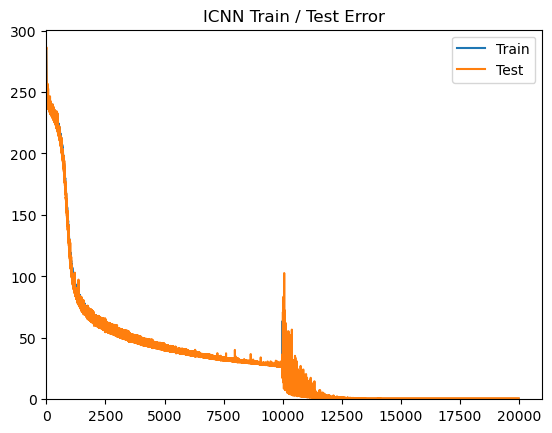

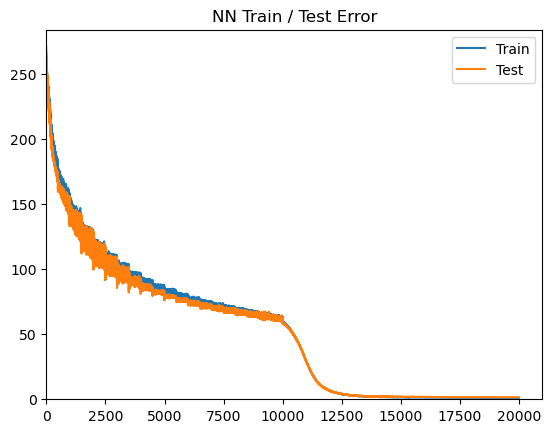

Average cost: $ 3495.16


In [45]:
# Show training/testing error
plt.title("ICNN Train / Test Error")
plt.plot(np.sqrt(np.array(icnn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(icnn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, None, 0, None])
plt.show()

plt.title("NN Train / Test Error")
plt.plot(np.sqrt(np.array(nn_train_history))[10:], label="Train")
plt.plot(np.sqrt(np.array(nn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, None, 0, None])
plt.show()

print(f"Average cost: $ {df_y.mean():.2f}")

In [46]:
### Experiment ###
# Compare NN, ICNN, and OPF solver on test data set

# Create test data tensor
test_loader = create_batches(X_test, y_test, batch_size=1, shuffle=False)

# Get NN, ICNN predictions
print("Getting NN / ICNN predictions...")
nn_pred_arr = pred(nn_model, test_loader)
icnn_pred_arr = pred(icnn_model, test_loader)
print("Done.")

# Get local search solver OPF predictions
print("Getting local search OPF solver predictions...")
Pd_test, Qd_test = X_test[:, :num_load_buses], X_test[:, num_load_buses:]
recalculate = False
if recalculate:
    lss_pred_arr = np.array([run_opf(case, Pd_test[i,:], Qd_test[i,:]) for i in range(X_test.shape[0])])
print("Done.")

# Save results
df_results = pd.DataFrame(columns=X_columns + ["Cost", "LSS Pred", "NN Pred", "ICNN Pred"])
df_results[X_columns] = X_test
df_results["Cost"] = y_test
df_results["LSS Pred"] = lss_pred_arr
df_results["NN Pred"] = nn_pred_arr
df_results["ICNN Pred"] = icnn_pred_arr

df_results.to_csv(results_dir / f"results_{case_name}_{input_dim}d_{num_samples}samples.csv")

# Calculate percent residuals
cost_arr = y_test.flatten()
nn_pct_residuals = (nn_pred_arr - cost_arr) / cost_arr
icnn_pct_residuals = (icnn_pred_arr - cost_arr) / cost_arr
lss_pct_residuals = (lss_pred_arr - cost_arr) / cost_arr

Getting NN / ICNN predictions...
Done.
Getting local search OPF solver predictions...
Done.


In [47]:
df_results["Cost"].std() / df_results["Cost"].mean()

np.float64(0.3844345616697315)

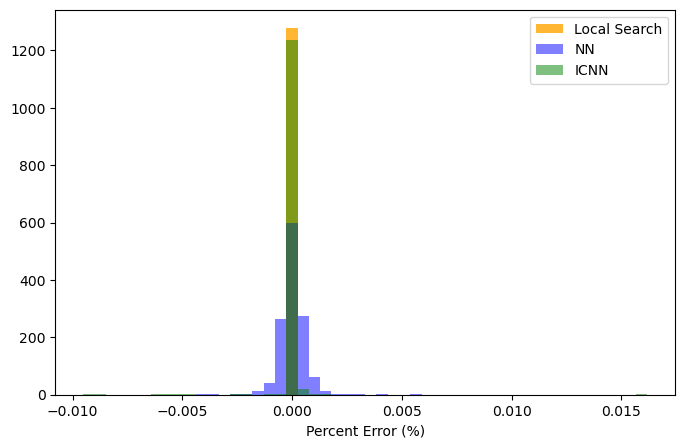

In [48]:
plt.figure(figsize=(8,5))
bins = np.linspace(min(min(lss_pct_residuals), min(nn_pct_residuals), min(icnn_pct_residuals)), max(max(lss_pct_residuals), max(nn_pct_residuals), max(icnn_pct_residuals)), 51)
plt.hist(lss_pct_residuals, bins=bins, color="orange", alpha=0.8, label="Local Search")
plt.hist(nn_pct_residuals, bins=bins, color="blue", alpha=0.5, label="NN")
plt.hist(icnn_pct_residuals, bins=bins, color="green", alpha=0.5, label="ICNN")
plt.legend()
plt.xlabel("Percent Error (%)")
plt.show()

In [49]:
print(f"LSS Error: {100 * np.mean(np.abs(lss_pct_residuals)):.2f} % Avg.  / {100 * np.abs(lss_pct_residuals).max():.2f} % Max.")
print(f"NN Error: {100 * np.mean(np.abs(nn_pct_residuals)):.2f} % Avg.  / {100 * np.abs(nn_pct_residuals).max():.2f} % Max.")
print(f"ICNN Error: {100 * np.mean(np.abs(icnn_pct_residuals)):.2f} % Avg.  / {100 * np.abs(icnn_pct_residuals).max():.2f} % Max.")

LSS Error: 0.00 % Avg.  / 0.00 % Max.
NN Error: 0.04 % Avg.  / 0.54 % Max.
ICNN Error: 0.01 % Avg.  / 1.62 % Max.


In [ ]:
plt.scatter(np.multiply(X_test, 1/X_test[0,:])[:,0], y_test, s=1)

In [68]:
import scipy.io
import pandas as pd

# Load the .mat file
mat_file_path = str(curr_dir / "training_data" / "temp" / "temp_case300_60d_100000samples.mat")
mat_data = scipy.io.loadmat(mat_file_path)

# Choose the variable to convert to DataFrame
variable_data = mat_data["cost_data"]

# Convert to DataFrame
df = pd.DataFrame(variable_data)

# Organize data
num_load_buses = int((len(df.columns) - 3) / 2)
print("Number of load buses: ", num_load_buses)
assert num_load_buses == len(load_buses)
X_columns = [f"Pd{i}" for i in load_buses] + [f"Qd{i}" for i in load_buses]
results_columns = ["Cost", "Feas_Flag", "Global_Opt"]

# Update columns
df.columns = X_columns + results_columns

# Save data
df.to_csv(curr_dir / "training_data" / "case300" / "training_case300_60d_100000samples.csv")

Number of load buses:  201


### Next thing to try: generating data from... DC OPF?

In [ ]:
import numpy as np
import pandapower as pp
import pandapower.networks as pn
from pandapower import rundcopp
from pandapower import OPFNotConverged

In [ ]:
case_name = "case9"
net = pn.case9()

In [ ]:
load_buses = net.load["bus"]
assert load_buses.is_unique

In [ ]:
d = 2 * len(load_buses) # Dimension of load vector subspace

# Think of uniformly sampling a hyper-cube in d-dimensions... N = 50,000 times
N = 5000

# We can just generate points in the hyper-cube, and scale them by their original ranges of values... E.g. [0, max(p_mw)] x [0, max(q_mvar)]
U = np.random.rand(N, d) # Uniform points in the hyper-cube
Pd = U[:, 0:len(load_buses)] * net.load["p_mw"].max()
Qd = U[:, len(load_buses):] * net.load["q_mvar"].max()

In [ ]:
columns=[f"P{k}" for k in load_buses] + [f"Q{k}" for k in load_buses] + ["Cost", "Feas"]
Pd_columns = [f"Pd{k}" for k in load_buses]
Qd_columns = [f"Qd{k}" for k in load_buses]

In [ ]:
df_results = pd.DataFrame(columns = Pd_columns + Qd_columns + ["Cost", "Feas"])

import time
start = time.time()
for i in range(N):
    net.load["p_mw"] = Pd[i, :]
    net.load["q_mvar"] = Qd[i, :]
    df_results.loc[i, Pd_columns] = net.load["p_mw"].values
    df_results.loc[i, Qd_columns] = net.load["q_mvar"].values
    try:
        rundcopp(net)
        feas = 1
        cost = net.res_cost
    except OPFNotConverged:
        print("Infeasible.")
        feas = 0
        cost = np.inf
    df_results.loc[i, "Cost"] = cost
    df_results.loc[i, "Feas"] = feas
end = time.time()
print(end - start)

In [ ]:
df_results.to_csv(curr_dir / "training_data" / f"DCOPF_{case_name}_{N}_samples.csv")

In [ ]:
df_results = pd.read_csv(curr_dir / "training_data" / "DCOPF_case9_5000_samples.csv")

In [ ]:
# Get feasible data points only
df_data = df_results.loc[df_results["Feas"] == 1]
print("Number of samples: ", len(df_data))

# Organize data
num_buses = int((len(df_data.columns) - 2) / 2)
print("Number of load buses: ", num_buses)
X_columns = Pd_columns + Qd_columns
assert set(X_columns).issubset(set(df_data.columns))
assert "Cost" in df_data.columns
df_X = df_data[X_columns]
df_y = df_data["Cost"]

# Get input data/labels
X, y = df_X.values.astype(np.float64), df_y.values.reshape(-1, 1).astype(np.float64)

### Train Neural Network(s)

# Initialize models
icnn_model = ICNN(input_dim=2 * num_buses)
nn_model = FCNN(input_dim=2 * num_buses)

# Train models

# Phase 1: SGD
nn_model, nn_train_history_phase1, nn_test_history_phase1 = train_model(
    nn_model,
    X,
    y,
    batch_size=200,
    optimizer="SGD", 
    n_epochs=8000,
    learning_rate=0.01,
    weight_decay=1e-9,
    scheduler_step_size=500,
    scheduler_gamma=0.9,
    max_norm=2.0
)

# Phase 2: Adam
nn_model, nn_train_history_phase2, nn_test_history_phase2 = train_model(
    nn_model,
    X,
    y,
    batch_size=50,
    optimizer="Adam", 
    n_epochs=8000,
    learning_rate=0.0001,
    weight_decay=1e-9,
    scheduler_step_size=500,
    scheduler_gamma=0.9,
    max_norm=1.0
)
nn_train_history = nn_train_history_phase1 + nn_train_history_phase2
nn_test_history = nn_test_history_phase1 + nn_test_history_phase2

# Phase 1: SGD
icnn_model, icnn_train_history_phase1, icnn_test_history_phase1 = train_model(
    icnn_model,
    X,
    y,
    batch_size=200,
    optimizer="SGD",
    n_epochs=8000,
    learning_rate=0.1,
    weight_decay=1e-9,
    scheduler_step_size=500,
    scheduler_gamma=0.8,
    max_norm=3.0
)

# Phase 2: Adam
icnn_model, icnn_train_history_phase2, icnn_test_history_phase2 = train_model(
    icnn_model,
    X,
    y,
    batch_size=50,
    optimizer="Adam",
    n_epochs=8000,
    learning_rate=0.001,
    weight_decay=1e-9,
    scheduler_step_size=500,
    scheduler_gamma=0.9,
    max_norm=3.0
)
icnn_train_history = icnn_train_history_phase1 + icnn_train_history_phase2
icnn_test_history = icnn_test_history_phase1 + icnn_test_history_phase2

In [ ]:
# Test model
plt.title("ICNN Train / Test Error")
plt.plot(np.sqrt(np.array(icnn_train_history))[10:], label="Train")
#plt.plot(np.sqrt(np.array(icnn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, None, 0, 200])
plt.show()

plt.title("NN Train / Test Error")
plt.plot(np.sqrt(np.array(nn_train_history))[10:], label="Train")
#plt.plot(np.sqrt(np.array(nn_test_history))[10:], label="Test")
plt.legend()
#plt.yscale('log')
plt.axis([0, None, 0, 200])
plt.show()

print(f"Average cost: $ {df_y.mean():.2f}")